In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

font = {
    "family": "Times New Roman",
    'size': 18
}

matplotlib.rc('font', **font)

df = pd.read_csv('../data/topo.csv')

df

,ip,DSW,PSW,ASW
0,0c9d9de1b19e7f39b08f49ddfa26744ae26d3adf8bd59a...,G6,P10,S14
1,525c32e31f7143b79af15f2bf2ec59f53aa1eae7ea72a4...,G6,P12,S2
2,99becf8368ffd875b7427c638393805310f415f19ec9a9...,G6,P10,S34
3,e3038539b9fc41eb81700d2bef4d67a017cb55c2bd21d5...,G6,P10,S6
4,cda65f227e38e764c8e5d3d2b3fdbcaa5f09fd0d28514b...,G6,P8,S3
...,...,...,...,...
842,a0e30dc4202875ad1a53cfc0d3856afdbe1336e397c5e7...,G6,P10,S12
843,6d5d92b79895a9eb36b2dea59425f6db1a29193d6893e2...,G6,P12,S23
844,d4856d9c39560eb2badd0dfd6b6d10f93dccd25193c483...,G6,P10,S40
845,605a41c369b964e388af701a41e0a5f9f8842c4c4dccfb...,G6,P10,S10


In [2]:
edges = set()

for _, row in df.iterrows():
    edges.add((row['ip'], row['ASW']))
    edges.add((row['ASW'], row['PSW']))
    edges.add((row['PSW'], row['DSW']))

len(edges)

969

Text(0, 0.5, 'Node Number')

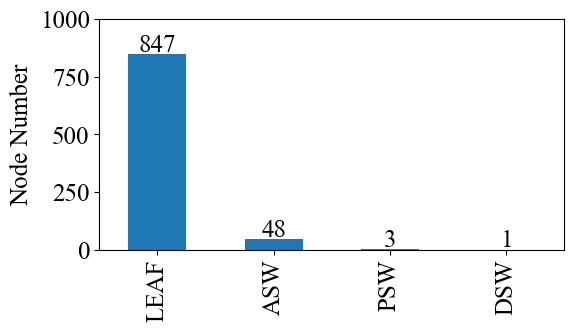

In [3]:
# construct the graph

import networkx as nx
from pyvis.network import Network
graph = nx.from_edgelist(list(edges))

attributes = {}
for _, row in df.iterrows():
    attributes[row['ip']] = "LEAF"
    attributes[row['ASW']] = "ASW"
    attributes[row['PSW']] = "PSW"
    attributes[row['DSW']] = "DSW"
nx.set_node_attributes(graph, attributes, 'type')

series = pd.Series([attr.get('type') for _, attr in graph.nodes(data=True)])
vc = series.value_counts()
fig, ax = plt.subplots(figsize=(6, 3))
vc.plot(kind='bar', ax=ax)
# Adding labels to the bars
for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2, p.get_height() + 10, str(p.get_height()), ha='center')
    
ax.set_ylim(0, 1000)
ax.set_ylabel("Node Number")


847 leaf nodes (machines), and the others are switches.

In [4]:
leaf_nodes = set([k for k, v in attributes.items() if v == 'LEAF'])
asw_nodes = set([k for k, v in attributes.items() if v == 'ASW'])
psw_nodes = set([k for k, v in attributes.items() if v == 'PSW'])
dsw_nodes = set([k for k, v in attributes.items() if v == 'DSW'])

list_northern_ports = []
list_southern_ports = []
list_nodes = []
list_types = []
for n, v in attributes.items():
    neighbors = list(graph.neighbors(n))
    if v == 'LEAF':
        northern_ports = len([neigh for neigh in neighbors if neigh in asw_nodes])
        southern_ports = 0
    elif v == 'ASW':
        northern_ports = len([neigh for neigh in neighbors if neigh in psw_nodes])
        southern_ports = len([neigh for neigh in neighbors if neigh in leaf_nodes])
    elif v == 'PSW':
        northern_ports = len([neigh for neigh in neighbors if neigh in dsw_nodes])
        southern_ports = len([neigh for neigh in neighbors if neigh in asw_nodes])
    elif v == 'DSW':
        northern_ports = 0
        southern_ports = len([neigh for neigh in neighbors if neigh in psw_nodes]) 
    else:
        raise RuntimeError("Unknown node type")

    assert northern_ports + southern_ports == len(neighbors), f"{n}"
    list_northern_ports.append(northern_ports)
    list_southern_ports.append(southern_ports)
    list_nodes.append(n)
    list_types.append(v)
        
    
df_nodes = pd.DataFrame({
    "node": list_nodes,
    "type": list_types,
    "num_northern_ports": list_northern_ports,
    "num_southern_ports": list_southern_ports
})
df_nodes['num_ports'] = df_nodes['num_northern_ports'] + df_nodes['num_southern_ports']
    
df_nodes


,node,type,num_northern_ports,num_southern_ports,num_ports
0,0c9d9de1b19e7f39b08f49ddfa26744ae26d3adf8bd59a...,LEAF,1,0,1
1,S14,ASW,3,19,22
2,P10,PSW,1,48,49
3,G6,DSW,0,3,3
4,525c32e31f7143b79af15f2bf2ec59f53aa1eae7ea72a4...,LEAF,1,0,1
...,...,...,...,...,...
894,a0e30dc4202875ad1a53cfc0d3856afdbe1336e397c5e7...,LEAF,1,0,1
895,6d5d92b79895a9eb36b2dea59425f6db1a29193d6893e2...,LEAF,1,0,1
896,d4856d9c39560eb2badd0dfd6b6d10f93dccd25193c483...,LEAF,1,0,1
897,605a41c369b964e388af701a41e0a5f9f8842c4c4dccfb...,LEAF,1,0,1


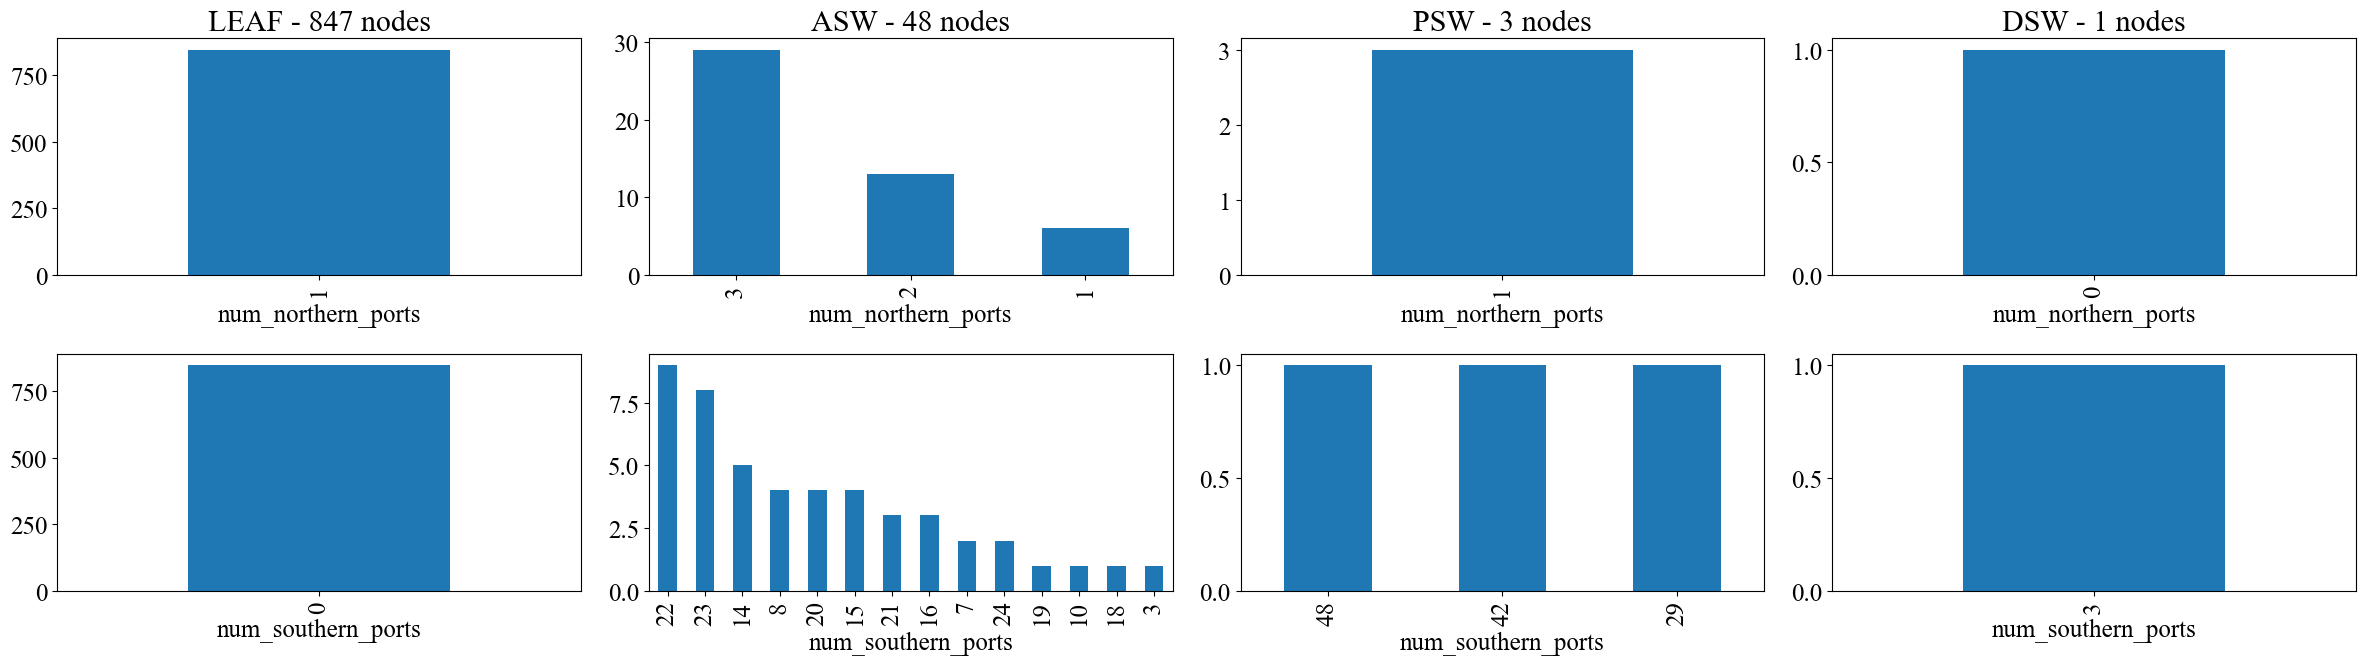

In [8]:
list_types = ['LEAF', 'ASW', 'PSW', 'DSW']

fig, axs = plt.subplots(2, 4, figsize=(24, 7))

for i, t in enumerate(list_types):
    vc = df_nodes[df_nodes['type'] == t]['num_northern_ports'].value_counts()
    vc.plot(kind='bar', ax=axs[0][i])
    vc = df_nodes[df_nodes['type'] == t]['num_southern_ports'].value_counts()
    vc.plot(kind='bar', ax=axs[1][i])
    axs[0][i].set_title(f"{t} - {len(df_nodes[df_nodes['type'] == t])} nodes")

plt.tight_layout()

All leaf nodes (machines) are connected to ASW nodes (ToR switches) via only a port.

The number of machines connected to a single ASW node (ToR switches) is up to 24.
Most of ASW have 22/23 machines connected.

The cluster is not balanced, with most racks have up to 22~24 machines, while some only have 3/7/8 machines.

All of 3 PSW switches connect to a single DSW root switch.
The number of ToR switches (ASW) connected to PSW switch is 48/42/29, respectively.